<a href="https://colab.research.google.com/github/00Matt000/Lung-cancer-ml-xai/blob/main/Lung-cancer-ml-xai%20/Models/code_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install lime
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto semestral TAIA/Dataset/lung_cancer_dataset.csv')
df.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,No,No,Yes,Moderate,No,No
1,100001,32,Female,12.780800,High,No,Yes,Yes,Moderate,Yes,Yes
2,100002,89,Female,0.408278,Medium,Yes,Yes,Yes,NaN,No,Yes
3,100003,78,Female,44.065232,Low,No,Yes,No,Moderate,No,Yes
4,100004,38,Female,44.432440,Medium,Yes,No,Yes,NaN,Yes,Yes


In [ ]:
df.isnull().sum()

,0
patient_id,0
age,0
gender,0
pack_years,0
radon_exposure,0
asbestos_exposure,0
secondhand_smoke_exposure,0
copd_diagnosis,0
alcohol_consumption,16662
family_history,0


In [ ]:
df = df.drop('patient_id', axis=1)

In [ ]:
df1 = df['alcohol_consumption']
df1 = df1.fillna("No")

df1.head()

,alcohol_consumption
0,Moderate
1,Moderate
2,No
3,Moderate
4,No


In [ ]:
df = df.drop('alcohol_consumption', axis=1)
df.head()

,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,family_history,lung_cancer
0,69,Male,66.025244,High,No,No,Yes,No,No
1,32,Female,12.780800,High,No,Yes,Yes,Yes,Yes
2,89,Female,0.408278,Medium,Yes,Yes,Yes,No,Yes
3,78,Female,44.065232,Low,No,Yes,No,No,Yes
4,38,Female,44.432440,Medium,Yes,No,Yes,Yes,Yes


In [ ]:
df1.replace(["No", "Moderate", "Heavy"], [0,1,2], inplace=True)

value_mapping = {
    0: "No",
    1: "Moderate",
    2: "Heavy"
}
value_mapping
df1.head()

/tmp/ipython-input-2297746902.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1.replace(["No", "Moderate", "Heavy"], [0,1,2], inplace=True)


,alcohol_consumption
0,1
1,1
2,0
3,1
4,0


In [ ]:
df2 = df['radon_exposure']

df2.head()

,radon_exposure
0,High
1,High
2,Medium
3,Low
4,Medium


In [ ]:
df = df.drop('radon_exposure', axis=1)
df.head()

,age,gender,pack_years,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,family_history,lung_cancer
0,69,Male,66.025244,No,No,Yes,No,No
1,32,Female,12.780800,No,Yes,Yes,Yes,Yes
2,89,Female,0.408278,Yes,Yes,Yes,No,Yes
3,78,Female,44.065232,No,Yes,No,No,Yes
4,38,Female,44.432440,Yes,No,Yes,Yes,Yes


In [ ]:
df2.replace(["Low", "Medium", "High"], [1,2,3], inplace=True)

value_mapping = {
    1: "Low",
    2: "Medium",
    3: "High"
}
value_mapping
df2.head()

/tmp/ipython-input-60606905.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2.replace(["Low", "Medium", "High"], [1,2,3], inplace=True)


,radon_exposure
0,3
1,3
2,2
3,1
4,2


In [ ]:
df3 = df.drop(columns=['age','pack_years', 'lung_cancer'], axis=1)
df3_binarias = df3.select_dtypes(include=['object']).columns
df3_binarias

Index(['gender', 'asbestos_exposure', 'secondhand_smoke_exposure',
       'copd_diagnosis', 'family_history'],
      dtype='object')

In [ ]:
count = {}
for i in df3_binarias:
    count[i] = df3[i].value_counts(normalize=True) * 100
    print(f"\nPercentage value counts for {i}:")
    print(round(count[i], 2))


Percentage value counts for gender:
gender
Female    50.17
Male      49.83
Name: proportion, dtype: float64

Percentage value counts for asbestos_exposure:
asbestos_exposure
No     50.3
Yes    49.7
Name: proportion, dtype: float64

Percentage value counts for secondhand_smoke_exposure:
secondhand_smoke_exposure
Yes    50.13
No     49.87
Name: proportion, dtype: float64

Percentage value counts for copd_diagnosis:
copd_diagnosis
Yes    50.13
No     49.87
Name: proportion, dtype: float64

Percentage value counts for family_history:
family_history
No     50.03
Yes    49.97
Name: proportion, dtype: float64


In [ ]:
ohe = OneHotEncoder()
ohe_df3 = ohe.fit_transform(df3[['gender', 'asbestos_exposure', 'secondhand_smoke_exposure','copd_diagnosis', 'family_history']])

df3_onehot_encoded = pd.DataFrame(ohe_df3.toarray(), columns=ohe.get_feature_names_out(['gender', 'asbestos_exposure', 'secondhand_smoke_exposure', 'copd_diagnosis', 'family_history']))

df3_onehot_encoded

,gender_Female,gender_Male,asbestos_exposure_No,asbestos_exposure_Yes,secondhand_smoke_exposure_No,secondhand_smoke_exposure_Yes,copd_diagnosis_No,copd_diagnosis_Yes,family_history_No,family_history_Yes
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
49995,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
49996,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
49997,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
49998,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
df4 = df[['age', 'pack_years']]

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df4)
df4 = pd.DataFrame(scaled_data, columns=['age', 'pack_years'])
df4.head()

,age,pack_years
0,0.423364,0.556701
1,-1.121004,-1.288746
2,1.258157,-1.717576
3,0.799021,-0.204431
4,-0.870566,-0.191703


In [ ]:
df5 = df[['lung_cancer']]

enconder = LabelEncoder()
df5['lung_cancer'] = enconder.fit_transform(df5['lung_cancer'])

df5.head()

/tmp/ipython-input-3995977187.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['lung_cancer'] = enconder.fit_transform(df5['lung_cancer'])


,lung_cancer
0,0
1,1
2,1
3,1
4,1


In [ ]:
df_final = pd.concat([df1, df2, df3_onehot_encoded, df4, df5], axis=1)
df_final.head()

,alcohol_consumption,radon_exposure,gender_Female,gender_Male,asbestos_exposure_No,asbestos_exposure_Yes,secondhand_smoke_exposure_No,secondhand_smoke_exposure_Yes,copd_diagnosis_No,copd_diagnosis_Yes,family_history_No,family_history_Yes,age,pack_years,lung_cancer
0,1,3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.423364,0.556701,0
1,1,3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.121004,-1.288746,1
2,0,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.258157,-1.717576,1
3,1,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.799021,-0.204431,1
4,0,2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.870566,-0.191703,1


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alcohol_consumption            50000 non-null  int64  
 1   radon_exposure                 50000 non-null  int64  
 2   gender_Female                  50000 non-null  float64
 3   gender_Male                    50000 non-null  float64
 4   asbestos_exposure_No           50000 non-null  float64
 5   asbestos_exposure_Yes          50000 non-null  float64
 6   secondhand_smoke_exposure_No   50000 non-null  float64
 7   secondhand_smoke_exposure_Yes  50000 non-null  float64
 8   copd_diagnosis_No              50000 non-null  float64
 9   copd_diagnosis_Yes             50000 non-null  float64
 10  family_history_No              50000 non-null  float64
 11  family_history_Yes             50000 non-null  float64
 12  age                            50000 non-null 

In [ ]:
df_final.isna().sum()

,0
alcohol_consumption,0
radon_exposure,0
gender_Female,0
gender_Male,0
asbestos_exposure_No,0
asbestos_exposure_Yes,0
secondhand_smoke_exposure_No,0
secondhand_smoke_exposure_Yes,0
copd_diagnosis_No,0
copd_diagnosis_Yes,0


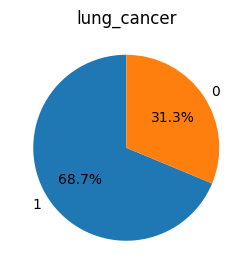

In [ ]:
plt.figure(figsize=(3, 4))
plt.pie(df_final['lung_cancer'].value_counts(), labels=df_final['lung_cancer'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('lung_cancer')
plt.show()

In [ ]:
X = df_final.drop('lung_cancer', axis=1)
y = df_final['lung_cancer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35000, 14)
X_test shape: (15000, 14)
y_train shape: (35000,)
y_test shape: (15000,)


In [ ]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['No Enfermedad', 'Enfermedad']
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

In [ ]:
best_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1,
    n_estimators=400,
    subsample=0.8,
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

umbral = 0.61

y_pred_xgb = (y_proba_xgb >= umbral).astype(int)

accuracy1 = accuracy_score(y_test, y_pred_xgb)

print("Accuracy of the XGBoost model:", accuracy1)

Accuracy of the XGBoost model: 0.7315333333333334


In [ ]:
print("\nClassification Report of the XGBoost Model WITHOUT Hyper-parameter Tuning:")
print(classification_report(y_test, y_pred_xgb))


Classification Report of the XGBoost Model WITHOUT Hyper-parameter Tuning:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      4691
           1       0.80      0.81      0.81     10309

    accuracy                           0.73     15000
   macro avg       0.69      0.69      0.69     15000
weighted avg       0.73      0.73      0.73     15000



In [ ]:
precision1 = precision_score(y_test, y_pred_xgb)
recall1 = recall_score(y_test, y_pred_xgb)
f11 = f1_score(y_test, y_pred_xgb)
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_xgb).ravel()
specificity1 = tn1 / (tn1 + fp1)

print("\n=== Métricas del modelo normal ===")
print(f"Accuracy    : {accuracy1:.4f}")
print(f"F1-Score    : {f11:.4f}")
print(f"Precision   : {precision1:.4f}")
print(f"Recall (Sensibilidad): {recall1:.4f}")
print(f"Specificity : {specificity1:.4f}")


=== Métricas del modelo normal ===
Accuracy    : 0.7315
F1-Score    : 0.8053
Precision   : 0.8028
Recall (Sensibilidad): 0.8077
Specificity : 0.5641


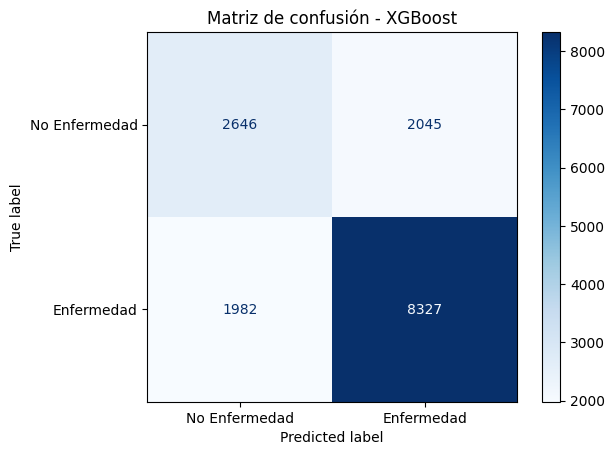

In [ ]:
plot_confusion(y_test, y_pred_xgb, "Matriz de confusión - XGBoost")

In [ ]:
#best_rf_model = RandomForestClassifier(
#    class_weight='balanced',
#    max_depth=10,
#    max_features='sqrt',
#    min_samples_leaf=4,
#    min_samples_split=2,
#    n_estimators=400,
#    random_state=42
#)

rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)

rf_model.fit(X_train, y_train)

best_rf_model = rf_model

In [ ]:
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

umbral = 0.61

y_pred_rf = (y_proba_rf >= umbral).astype(int)

accuracy2 = accuracy_score(y_test, y_pred_rf)

print("Accuracy of the RF model:", accuracy2)

Accuracy of the RF model: 0.7271333333333333


In [ ]:
print("\nClassification Report of the Random Forest Model WITHOUT Hyper-parameter Tuning:")
print(classification_report(y_test, y_pred_rf))


Classification Report of the Random Forest Model WITHOUT Hyper-parameter Tuning:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      4691
           1       0.80      0.81      0.80     10309

    accuracy                           0.73     15000
   macro avg       0.68      0.68      0.68     15000
weighted avg       0.73      0.73      0.73     15000



In [ ]:
precision2 = precision_score(y_test, y_pred_rf)
recall2 = recall_score(y_test, y_pred_rf)
f12 = f1_score(y_test, y_pred_rf)
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_pred_rf).ravel()
specificity2 = tn2 / (tn2 + fp2)

print("\n=== Métricas del modelo normal ===")
print(f"Accuracy    : {accuracy2:.4f}")
print(f"F1-Score    : {f12:.4f}")
print(f"Precision   : {precision2:.4f}")
print(f"Recall (Sensibilidad): {recall2:.4f}")
print(f"Specificity : {specificity2:.4f}")


=== Métricas del modelo normal ===
Accuracy    : 0.7271
F1-Score    : 0.8023
Precision   : 0.7991
Recall (Sensibilidad): 0.8054
Specificity : 0.5551


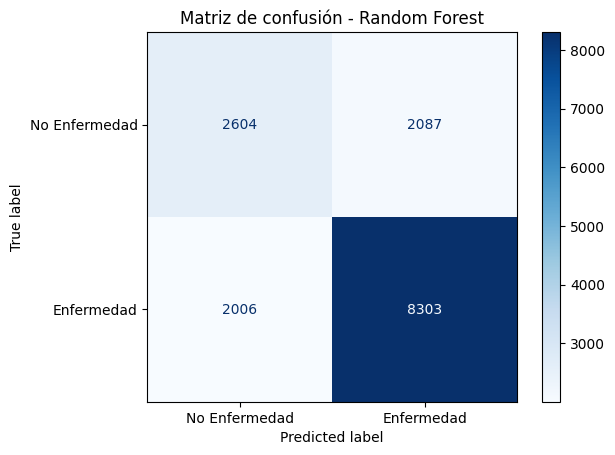

In [ ]:
plot_confusion(y_test, y_pred_rf, "Matriz de confusión - Random Forest")

In [ ]:
best_svm_model = SVC(
    C=0.1,
    class_weight='balanced',
    gamma='scale',
    random_state=42,
    kernel='rbf',
    probability=True
)

best_svm_model.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', probability=True, random_state=42)

In [ ]:
y_pred_svm = best_svm_model.predict(X_test)

accuracy3 = accuracy_score(y_test, y_pred_svm)

print("Accuracy of the SVM model:", accuracy3)

Accuracy of the SVM model: 0.6643333333333333


In [ ]:
print("\nClassification Report of the Random Forest Model WITHOUT Hyper-parameter Tuning:")
print(classification_report(y_test, y_pred_svm))


Classification Report of the Random Forest Model WITHOUT Hyper-parameter Tuning:
              precision    recall  f1-score   support

           0       0.48      0.73      0.58      4691
           1       0.84      0.63      0.72     10309

    accuracy                           0.66     15000
   macro avg       0.66      0.68      0.65     15000
weighted avg       0.72      0.66      0.68     15000



In [ ]:
precision3 = precision_score(y_test, y_pred_svm)
recall3 = recall_score(y_test, y_pred_svm)
f13 = f1_score(y_test, y_pred_svm)
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, y_pred_svm).ravel()
specificity3 = tn3 / (tn3 + fp3)

print("\n=== Métricas del modelo normal ===")
print(f"Accuracy    : {accuracy3:.4f}")
print(f"F1-Score    : {f13:.4f}")
print(f"Precision   : {precision3:.4f}")
print(f"Recall (Sensibilidad): {recall3:.4f}")
print(f"Specificity : {specificity3:.4f}")


=== Métricas del modelo normal ===
Accuracy    : 0.6643
F1-Score    : 0.7222
Precision   : 0.8375
Recall (Sensibilidad): 0.6348
Specificity : 0.7293


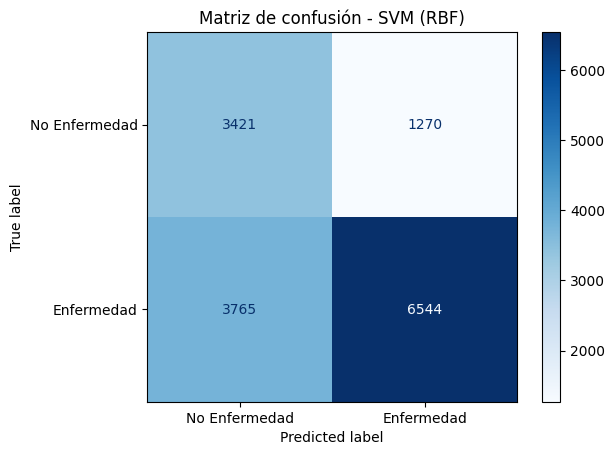

In [ ]:
plot_confusion(y_test, y_pred_svm, "Matriz de confusión - SVM (RBF)")

In [ ]:
best_lgbm_model = LGBMClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    min_child_samples=20,
    n_estimators=400,
    num_leaves=63,
    subsample=0.8,
    random_state=42
)

best_lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24055, number of negative: 10945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.687286 -> initscore=0.787460
[LightGBM] [Info] Start training from score 0.787460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(max_depth=7, n_estimators=400, num_leaves=63, random_state=42,
               subsample=0.8)

In [ ]:
y_proba_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

umbral = 0.61

y_pred_lgbm = (y_proba_lgbm >= umbral).astype(int)

accuracy4 = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy of the lgbm model:", accuracy4)

Accuracy of the lgbm model: 0.7079333333333333


In [ ]:
precision4 = precision_score(y_test, y_pred_lgbm)
recall4 = recall_score(y_test, y_pred_lgbm)
f14 = f1_score(y_test, y_pred_lgbm)
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, y_pred_lgbm).ravel()
specificity4 = tn4 / (tn4 + fp4)

print("\n=== Métricas del modelo normal ===")
print(f"Accuracy    : {accuracy4:.4f}")
print(f"F1-Score    : {f14:.4f}")
print(f"Precision   : {precision4:.4f}")
print(f"Recall (Sensibilidad): {recall4:.4f}")
print(f"Specificity : {specificity4:.4f}")


=== Métricas del modelo normal ===
Accuracy    : 0.7079
F1-Score    : 0.7845
Precision   : 0.7957
Recall (Sensibilidad): 0.7737
Specificity : 0.5634


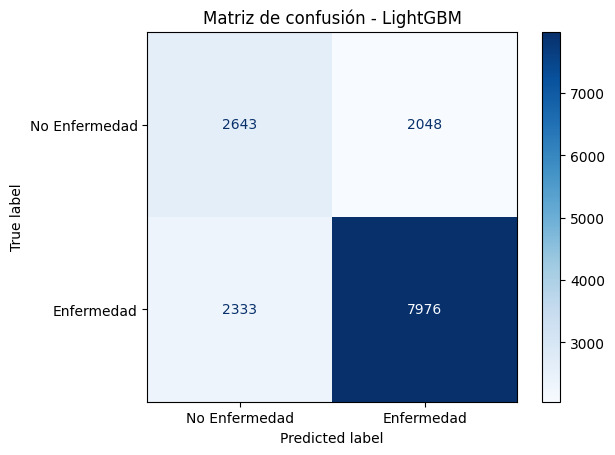

In [ ]:
plot_confusion(y_test, y_pred_lgbm, "Matriz de confusión - LightGBM")

In [ ]:
best_logreg_model = LogisticRegression(
    C=10,
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)

best_logreg_model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [ ]:
y_pred_logreg = best_logreg_model.predict(X_test)

accuracy5 = accuracy_score(y_test, y_pred_logreg)
print("Accuracy of the Logistic Regression model:", accuracy5)

Accuracy of the Logistic Regression model: 0.6644


In [ ]:
precision5 = precision_score(y_test, y_pred_logreg)
recall5 = recall_score(y_test, y_pred_logreg)
f15 = f1_score(y_test, y_pred_logreg)
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, y_pred_logreg).ravel()
specificity5 = tn5 / (tn5 + fp5)

print("\n=== Métricas del modelo normal ===")
print(f"Accuracy    : {accuracy5:.4f}")
print(f"F1-Score    : {f15:.4f}")
print(f"Precision   : {precision5:.4f}")
print(f"Recall (Sensibilidad): {recall5:.4f}")
print(f"Specificity : {specificity5:.4f}")


=== Métricas del modelo normal ===
Accuracy    : 0.6644
F1-Score    : 0.7300
Precision   : 0.8164
Recall (Sensibilidad): 0.6601
Specificity : 0.6738


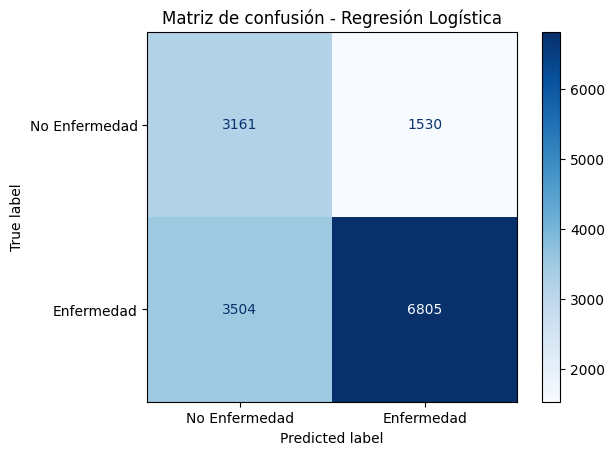

In [ ]:
plot_confusion(y_test, y_pred_logreg, "Matriz de confusión - Regresión Logística")

In [ ]:
resultados_modelos = pd.DataFrame({
    'Modelo': [
        'XGBoost',
        'Random Forest',
        'SVM (RBF)',
        'LightGBM',
        'Regresión Logística'
    ],
    'Accuracy': [
        accuracy1,
        accuracy2,
        accuracy3,
        accuracy4,
        accuracy5
    ],
    'Precision': [
        precision1,
        precision2,
        precision3,
        precision4,
        precision5
    ],
    'Recall': [
        recall1,
        recall2,
        recall3,
        recall4,
        recall5
    ],
    'F1-Score': [
        f11,
        f12,
        f13,
        f14,
        f15
    ],
    'Specificity': [
        specificity1,
        specificity2,
        specificity3,
        specificity4,
        specificity5
    ]
})

resultados_modelos.set_index('Modelo', inplace=True)

display(resultados_modelos)

,Accuracy,Precision,Recall,F1-Score,Specificity
Modelo,,,,,
XGBoost,0.731533,0.802835,0.807741,0.805280,0.564059
Random Forest,0.727133,0.799134,0.805413,0.802261,0.555106
SVM (RBF),0.664333,0.837471,0.634785,0.722176,0.729269
LightGBM,0.707933,0.795690,0.773693,0.784537,0.563419
Regresión Logística,0.664400,0.816437,0.660103,0.729994,0.673844


In [ ]:
feature_names = X_train.columns.tolist()

class_names = ['No cáncer', 'Cáncer']

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

In [ ]:
def explicar_con_lime(model, model_name, index_instance):

    x = X_test.iloc[index_instance].values


    exp = explainer.explain_instance(
        data_row=x,
        predict_fn=model.predict_proba,
        num_features=10
    )

    print(f"\n=== Explicación LIME para {model_name} ===")
    print(f"Índice de la instancia en X_test: {index_instance}")
    print(f"Etiqueta real (y_test): {y_test.iloc[index_instance]}")
    print("\nContribución de las características (feature, weight):")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")

    fig = exp.as_pyplot_figure()
    plt.title(f"LIME - {model_name} (instancia {index_instance})")
    plt.tight_layout()
    plt.show()

In [ ]:
idx_pos1 = np.where(y_test.values == 1)[0][0]
print("Índice elegido para explicación LIME:", idx_pos)
print("y_test en ese índice:", y_test.iloc[idx_pos])


Índice elegido para explicación LIME: 0
y_test en ese índice: 1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Explicación LIME para Random Forest ===
Índice de la instancia en X_test: 0
Etiqueta real (y_test): 1

Contribución de las características (feature, weight):
pack_years > 0.87: 0.0864
copd_diagnosis_Yes <= 0.00: -0.0786
asbestos_exposure_No <= 0.00: 0.0774
0.00 < copd_diagnosis_No <= 1.00: -0.0761
0.00 < asbestos_exposure_Yes <= 1.00: 0.0745
radon_exposure <= 1.00: -0.0614
0.00 < family_history_No <= 1.00: -0.0455
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0450
family_history_Yes <= 0.00: -0.0423
secondhand_smoke_exposure_Yes <= 0.00: -0.0380


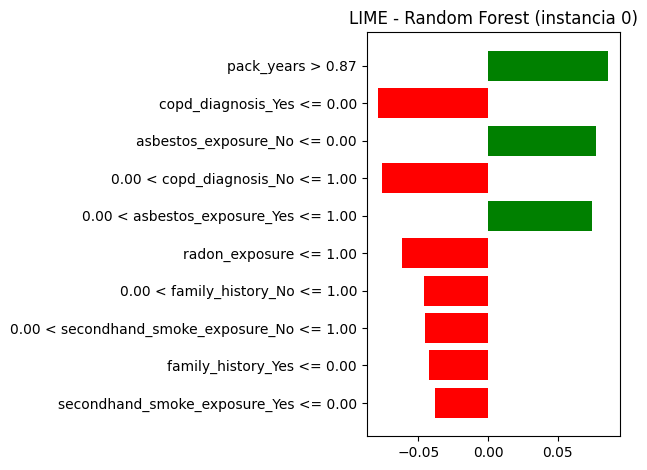


=== Explicación LIME para XGBoost ===
Índice de la instancia en X_test: 0
Etiqueta real (y_test): 1

Contribución de las características (feature, weight):
asbestos_exposure_No <= 0.00: 0.1366
0.00 < copd_diagnosis_No <= 1.00: -0.1036
pack_years > 0.87: 0.0935
0.00 < family_history_No <= 1.00: -0.0799
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0697
radon_exposure <= 1.00: -0.0605
-0.87 < age <= 0.01: -0.0496
1.00 < alcohol_consumption <= 2.00: 0.0333
copd_diagnosis_Yes <= 0.00: -0.0316
0.00 < asbestos_exposure_Yes <= 1.00: 0.0164


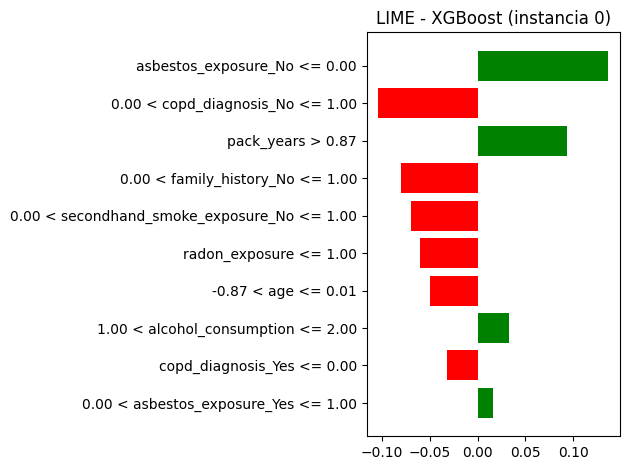

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



=== Explicación LIME para SVM (RBF) ===
Índice de la instancia en X_test: 0
Etiqueta real (y_test): 1

Contribución de las características (feature, weight):
pack_years > 0.87: 0.0887
asbestos_exposure_No <= 0.00: 0.0670
0.00 < asbestos_exposure_Yes <= 1.00: 0.0649
copd_diagnosis_Yes <= 0.00: -0.0646
0.00 < copd_diagnosis_No <= 1.00: -0.0642
0.00 < family_history_No <= 1.00: -0.0447
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0427
family_history_Yes <= 0.00: -0.0405
secondhand_smoke_exposure_Yes <= 0.00: -0.0350
1.00 < alcohol_consumption <= 2.00: 0.0185


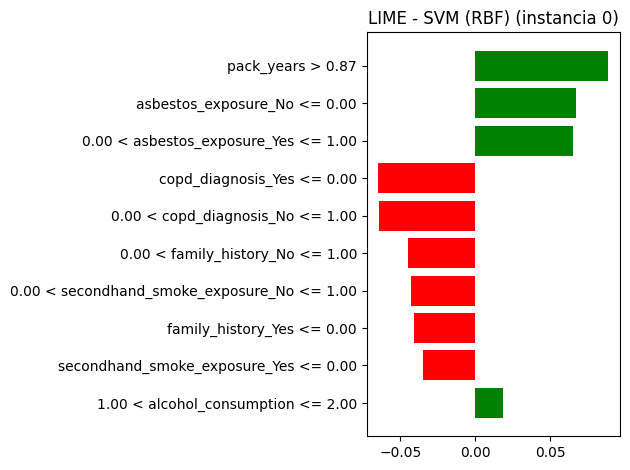

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



=== Explicación LIME para Regresión Logística ===
Índice de la instancia en X_test: 0
Etiqueta real (y_test): 1

Contribución de las características (feature, weight):
radon_exposure <= 1.00: -0.2034
pack_years > 0.87: 0.1841
0.00 < copd_diagnosis_No <= 1.00: -0.1101
asbestos_exposure_No <= 0.00: 0.1065
0.00 < family_history_No <= 1.00: -0.0819
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0738
copd_diagnosis_Yes <= 0.00: -0.0676
0.00 < asbestos_exposure_Yes <= 1.00: 0.0610
-0.87 < age <= 0.01: -0.0410
family_history_Yes <= 0.00: -0.0397


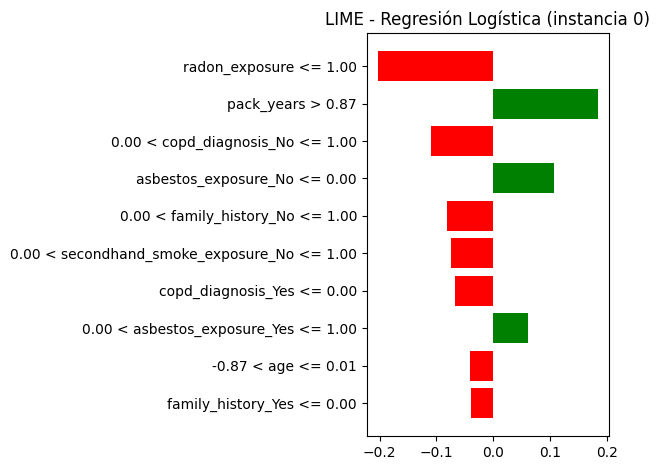

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Explicación LIME para LightGBM ===
Índice de la instancia en X_test: 0
Etiqueta real (y_test): 1

Contribución de las características (feature, weight):
0.00 < copd_diagnosis_No <= 1.00: -0.1492
asbestos_exposure_No <= 0.00: 0.1473
0.00 < family_history_No <= 1.00: -0.0985
pack_years > 0.87: 0.0922
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0760
radon_exposure <= 1.00: -0.0701
-0.87 < age <= 0.01: -0.0492
1.00 < alcohol_consumption <= 2.00: 0.0305
0.00 < gender_Female <= 1.00: 0.0067
0.00 < asbestos_exposure_Yes <= 1.00: -0.0049


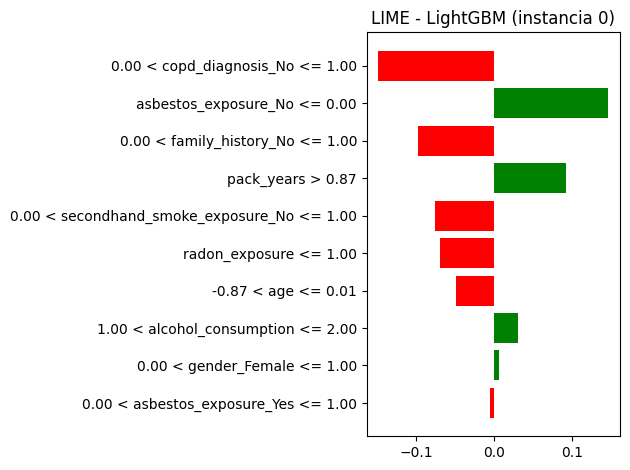

In [ ]:
explicar_con_lime(best_rf_model, "Random Forest", idx_pos1)

explicar_con_lime(best_xgb_model, "XGBoost", idx_pos1)

explicar_con_lime(best_svm_model, "SVM (RBF)", idx_pos1)

explicar_con_lime(best_logreg_model, "Regresión Logística", idx_pos1)

explicar_con_lime(best_lgbm_model, "LightGBM", idx_pos1)


In [ ]:
idx_pos2 = np.where(y_test.values == 0)[0][0]
print("Índice elegido para explicación LIME:", idx_pos2)
print("y_test en ese índice:", y_test.iloc[idx_pos2])

Índice elegido para explicación LIME: 1
y_test en ese índice: 0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Explicación LIME para Random Forest ===
Índice de la instancia en X_test: 1
Etiqueta real (y_test): 0

Contribución de las características (feature, weight):
0.01 < pack_years <= 0.87: 0.1007
age <= -0.87: -0.1002
asbestos_exposure_Yes <= 0.00: -0.0767
copd_diagnosis_Yes <= 0.00: -0.0762
0.00 < copd_diagnosis_No <= 1.00: -0.0759
0.00 < asbestos_exposure_No <= 1.00: -0.0710
1.00 < radon_exposure <= 2.00: -0.0560
family_history_No <= 0.00: 0.0459
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0448
0.00 < family_history_Yes <= 1.00: 0.0405


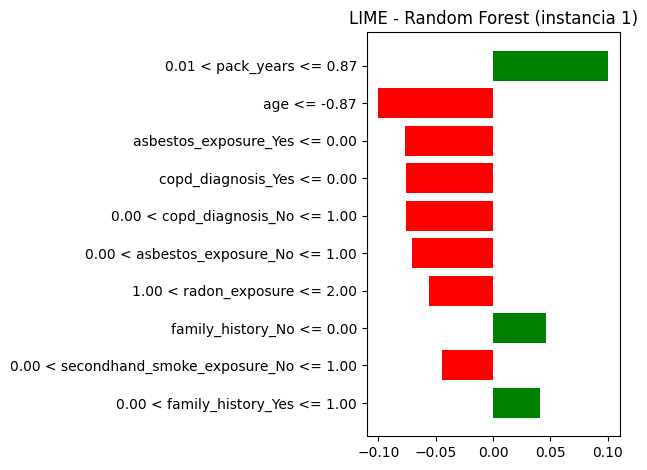


=== Explicación LIME para XGBoost ===
Índice de la instancia en X_test: 1
Etiqueta real (y_test): 0

Contribución de las características (feature, weight):
0.00 < asbestos_exposure_No <= 1.00: -0.1343
0.00 < copd_diagnosis_No <= 1.00: -0.1134
age <= -0.87: -0.1070
0.01 < pack_years <= 0.87: 0.0980
family_history_No <= 0.00: 0.0865
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0758
1.00 < radon_exposure <= 2.00: -0.0676
copd_diagnosis_Yes <= 0.00: -0.0346
asbestos_exposure_Yes <= 0.00: -0.0172
0.00 < family_history_Yes <= 1.00: 0.0128


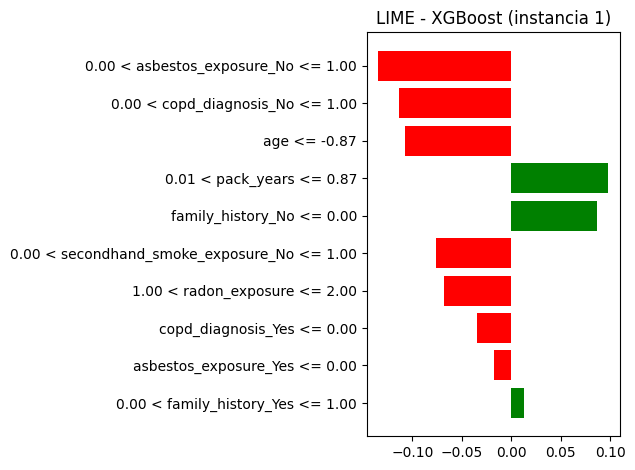

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



=== Explicación LIME para SVM (RBF) ===
Índice de la instancia en X_test: 1
Etiqueta real (y_test): 0

Contribución de las características (feature, weight):
age <= -0.87: -0.1113
0.01 < pack_years <= 0.87: 0.1087
0.00 < asbestos_exposure_No <= 1.00: -0.0693
1.00 < radon_exposure <= 2.00: -0.0691
0.00 < copd_diagnosis_No <= 1.00: -0.0677
asbestos_exposure_Yes <= 0.00: -0.0637
copd_diagnosis_Yes <= 0.00: -0.0636
family_history_No <= 0.00: 0.0420
0.00 < family_history_Yes <= 1.00: 0.0382
secondhand_smoke_exposure_Yes <= 0.00: -0.0373


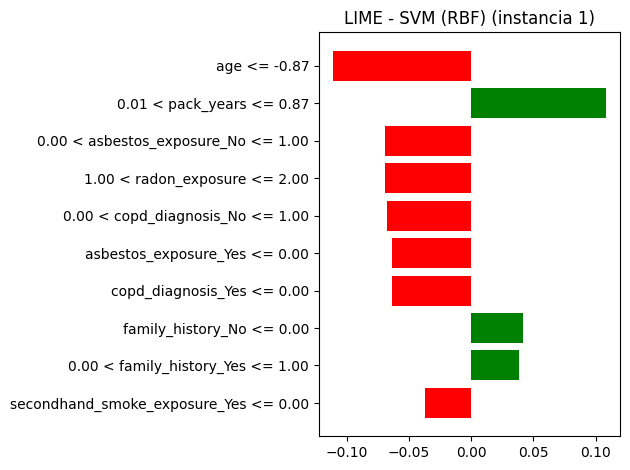


=== Explicación LIME para Regresión Logística ===
Índice de la instancia en X_test: 1
Etiqueta real (y_test): 0

Contribución de las características (feature, weight):
age <= -0.87: -0.1193
0.00 < copd_diagnosis_No <= 1.00: -0.1068
0.00 < asbestos_exposure_No <= 1.00: -0.1030
family_history_No <= 0.00: 0.0799
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0786
asbestos_exposure_Yes <= 0.00: -0.0707
0.01 < pack_years <= 0.87: 0.0654
copd_diagnosis_Yes <= 0.00: -0.0609
0.00 < family_history_Yes <= 1.00: 0.0422
1.00 < radon_exposure <= 2.00: 0.0374


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


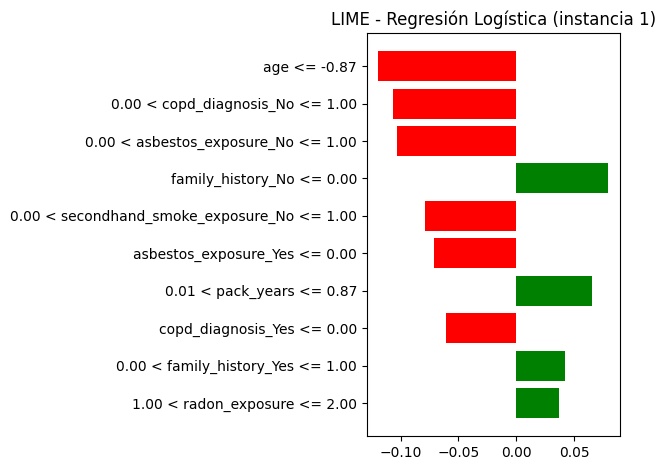

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Explicación LIME para LightGBM ===
Índice de la instancia en X_test: 1
Etiqueta real (y_test): 0

Contribución de las características (feature, weight):
0.00 < copd_diagnosis_No <= 1.00: -0.1589
0.00 < asbestos_exposure_No <= 1.00: -0.1568
family_history_No <= 0.00: 0.1065
0.01 < pack_years <= 0.87: 0.1035
age <= -0.87: -0.1005
0.00 < secondhand_smoke_exposure_No <= 1.00: -0.0783
1.00 < radon_exposure <= 2.00: -0.0616
0.00 < alcohol_consumption <= 1.00: -0.0194
copd_diagnosis_Yes <= 0.00: -0.0083
gender_Female <= 0.00: 0.0058


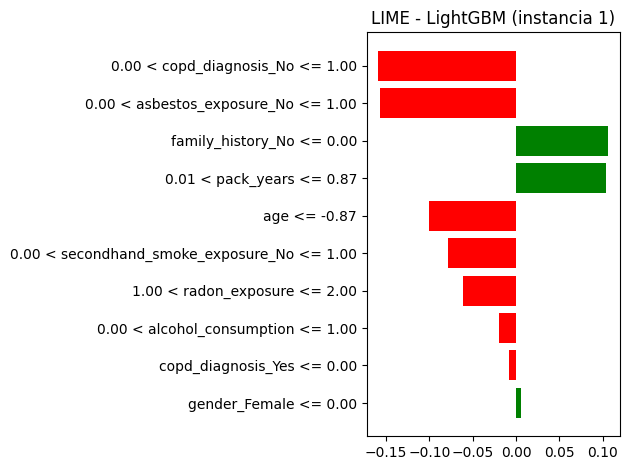

In [ ]:
explicar_con_lime(best_rf_model, "Random Forest", idx_pos2)

explicar_con_lime(best_xgb_model, "XGBoost", idx_pos2)

explicar_con_lime(best_svm_model, "SVM (RBF)", idx_pos2)

explicar_con_lime(best_logreg_model, "Regresión Logística", idx_pos2)

explicar_con_lime(best_lgbm_model, "LightGBM", idx_pos2)


In [ ]:
def mostrar_permutation_importance(model, model_name, X_val, y_val, scoring='f1', top_n=15):

    print(f"\n=== Permutation Feature Importance para {model_name} (scoring = {scoring}) ===")

    result = permutation_importance(
        estimator=model,
        X=X_val,
        y=y_val,
        n_repeats=30,
        random_state=42,
        scoring=scoring,
        n_jobs=-1
    )

    importances_mean = result.importances_mean
    importances_std = result.importances_std
    indices = np.argsort(importances_mean)[::-1]

    print(f"\nTop {top_n} características más importantes:")
    for idx in indices[:top_n]:
        print(f"{feature_names[idx]:<25}  {importances_mean[idx]: .4f} ± {importances_std[idx]: .4f}")

    top_idx = indices[:top_n]
    plt.figure(figsize=(8, max(4, top_n * 0.3)))
    plt.barh(range(len(top_idx)), importances_mean[top_idx])
    plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx])
    plt.gca().invert_yaxis()
    plt.xlabel(f"Disminución media en {scoring}")
    plt.title(f"Permutation Importance - {model_name}")
    plt.tight_layout()
    plt.show()



=== Permutation Feature Importance para Random Forest (scoring = f1) ===

Top 15 características más importantes:
pack_years                  0.0460 ±  0.0014
age                         0.0065 ±  0.0011
radon_exposure              0.0042 ±  0.0009
copd_diagnosis_Yes          0.0010 ±  0.0007
copd_diagnosis_No           0.0007 ±  0.0007
asbestos_exposure_Yes       0.0005 ±  0.0009
asbestos_exposure_No        0.0004 ±  0.0008
secondhand_smoke_exposure_No   0.0004 ±  0.0006
alcohol_consumption         0.0002 ±  0.0007
secondhand_smoke_exposure_Yes  -0.0001 ±  0.0005
family_history_No          -0.0003 ±  0.0005
family_history_Yes         -0.0003 ±  0.0005
gender_Male                -0.0004 ±  0.0005
gender_Female              -0.0005 ±  0.0006


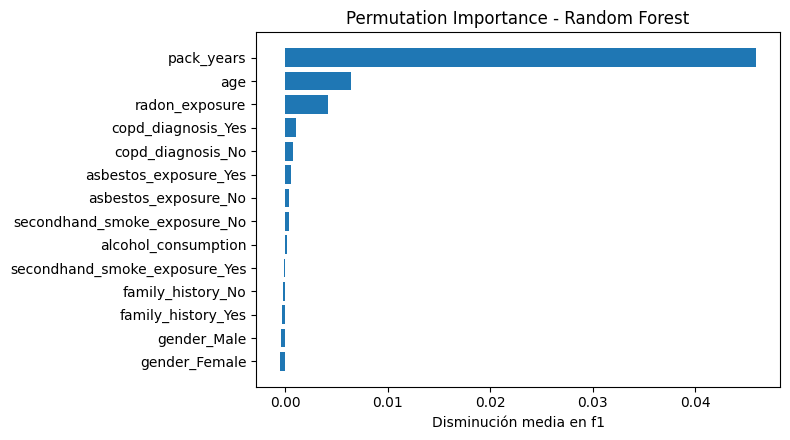


=== Permutation Feature Importance para XGBoost (scoring = f1) ===

Top 15 características más importantes:
pack_years                  0.0464 ±  0.0013
age                         0.0092 ±  0.0011
asbestos_exposure_No        0.0065 ±  0.0010
radon_exposure              0.0062 ±  0.0009
family_history_No           0.0025 ±  0.0011
copd_diagnosis_No           0.0024 ±  0.0010
secondhand_smoke_exposure_No   0.0020 ±  0.0008
alcohol_consumption         0.0002 ±  0.0006
gender_Male                -0.0000 ±  0.0001
gender_Female              -0.0005 ±  0.0003
family_history_Yes         -0.0005 ±  0.0005
copd_diagnosis_Yes         -0.0006 ±  0.0006
secondhand_smoke_exposure_Yes  -0.0008 ±  0.0004
asbestos_exposure_Yes      -0.0008 ±  0.0004


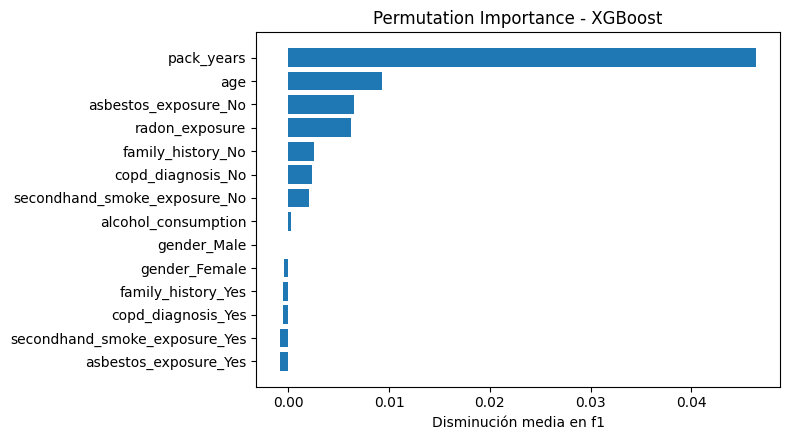


=== Permutation Feature Importance para SVM (RBF) (scoring = f1) ===

Top 15 características más importantes:
pack_years                  0.0515 ±  0.0025
age                         0.0144 ±  0.0023
radon_exposure              0.0115 ±  0.0018
asbestos_exposure_No        0.0033 ±  0.0019
asbestos_exposure_Yes       0.0033 ±  0.0019
alcohol_consumption         0.0023 ±  0.0008
copd_diagnosis_Yes          0.0022 ±  0.0014
copd_diagnosis_No           0.0022 ±  0.0014
gender_Female              -0.0000 ±  0.0005
gender_Male                -0.0000 ±  0.0005
family_history_Yes         -0.0003 ±  0.0011
family_history_No          -0.0003 ±  0.0011
secondhand_smoke_exposure_Yes  -0.0005 ±  0.0010
secondhand_smoke_exposure_No  -0.0005 ±  0.0010


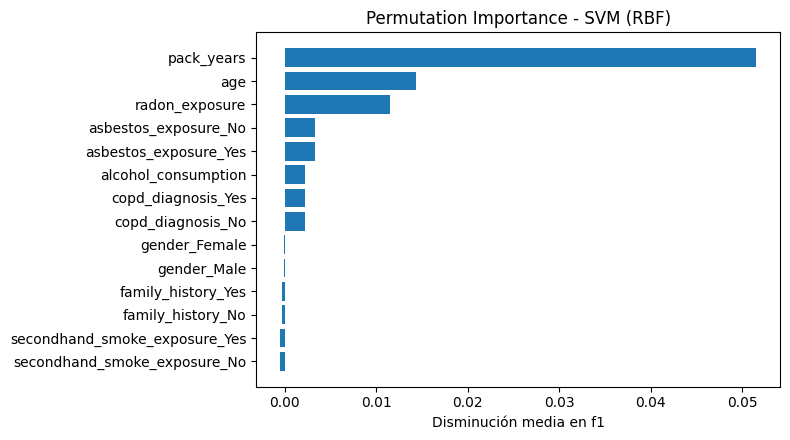


=== Permutation Feature Importance para Regresión Logística (scoring = f1) ===

Top 15 características más importantes:
pack_years                  0.0339 ±  0.0029
age                         0.0099 ±  0.0021
radon_exposure              0.0081 ±  0.0017
asbestos_exposure_No        0.0059 ±  0.0018
secondhand_smoke_exposure_No   0.0033 ±  0.0011
asbestos_exposure_Yes       0.0023 ±  0.0011
family_history_No           0.0022 ±  0.0015
copd_diagnosis_No           0.0017 ±  0.0015
alcohol_consumption         0.0013 ±  0.0008
secondhand_smoke_exposure_Yes   0.0006 ±  0.0008
gender_Male                 0.0004 ±  0.0005
family_history_Yes          0.0003 ±  0.0010
copd_diagnosis_Yes          0.0003 ±  0.0011
gender_Female               0.0001 ±  0.0008


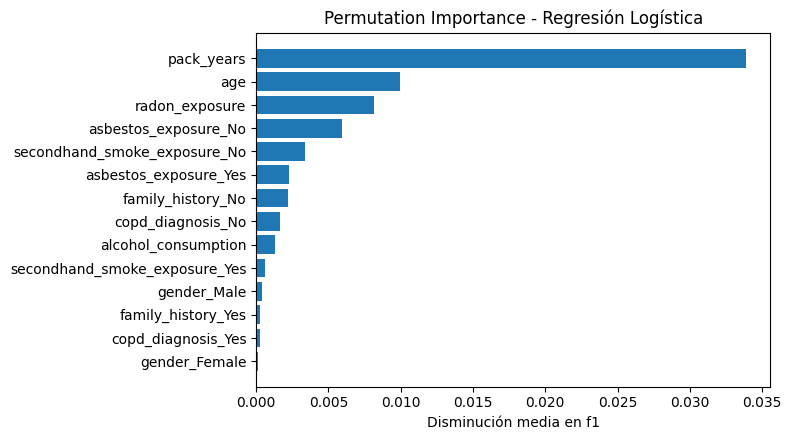


=== Permutation Feature Importance para LightGBM (scoring = f1) ===

Top 15 características más importantes:
pack_years                  0.0446 ±  0.0020
age                         0.0103 ±  0.0016
asbestos_exposure_No        0.0082 ±  0.0013
copd_diagnosis_No           0.0080 ±  0.0011
radon_exposure              0.0062 ±  0.0010
family_history_No           0.0045 ±  0.0009
secondhand_smoke_exposure_No   0.0038 ±  0.0009
alcohol_consumption         0.0011 ±  0.0008
copd_diagnosis_Yes          0.0002 ±  0.0002
family_history_Yes          0.0001 ±  0.0002
gender_Male                 0.0000 ±  0.0002
asbestos_exposure_Yes      -0.0000 ±  0.0003
secondhand_smoke_exposure_Yes  -0.0003 ±  0.0002
gender_Female              -0.0007 ±  0.0006


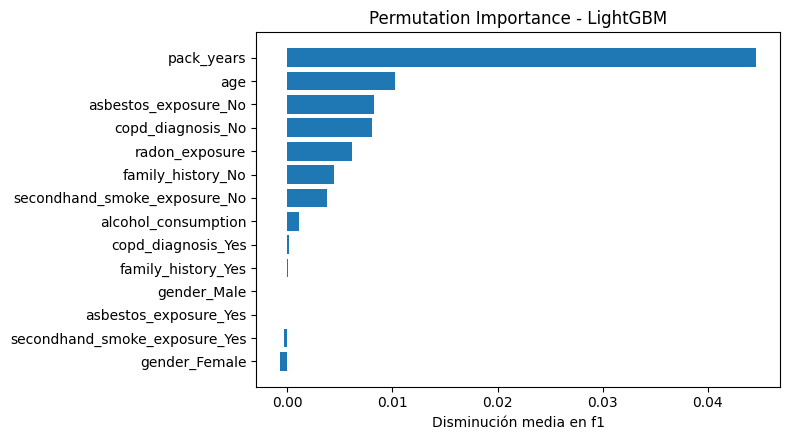

In [ ]:
mostrar_permutation_importance(best_rf_model, "Random Forest", X_test, y_test, scoring='f1', top_n=15)

mostrar_permutation_importance(best_xgb_model, "XGBoost", X_test, y_test, scoring='f1', top_n=15)

mostrar_permutation_importance(best_svm_model, "SVM (RBF)", X_test, y_test, scoring='f1', top_n=15)

mostrar_permutation_importance(best_logreg_model, "Regresión Logística", X_test, y_test, scoring='f1', top_n=15)

mostrar_permutation_importance(best_lgbm_model, "LightGBM", X_test, y_test, scoring='f1', top_n=15)

In [ ]:
def entrenar_arbol_sustituto(modelo, X_train_model, X_test_model, feature_names, nombre_modelo, max_depth=3):

    y_train_hat = modelo.predict(X_train_model)
    y_test_hat  = modelo.predict(X_test_model)

    surrogate = DecisionTreeClassifier(
        max_depth=max_depth,
        random_state=42
    )
    surrogate.fit(X_train_model, y_train_hat)

    y_train_sur = surrogate.predict(X_train_model)
    y_test_sur  = surrogate.predict(X_test_model)

    fidelidad_train = accuracy_score(y_train_hat, y_train_sur)
    fidelidad_test  = accuracy_score(y_test_hat, y_test_sur)

    print(f"\n=== Árbol sustituto para {nombre_modelo} ===")
    print(f"Fidelidad (train) modelo vs árbol: {fidelidad_train:.4f}")
    print(f"Fidelidad (test)  modelo vs árbol: {fidelidad_test:.4f}")

    print("\nReglas del árbol (forma textual):")
    print(export_text(surrogate, feature_names=list(feature_names)))

    plt.figure(figsize=(16, 6))
    plot_tree(
        surrogate,
        feature_names=feature_names,
        class_names=["No cáncer", "Cáncer"],
        filled=True,
        rounded=True,
        fontsize=8
    )
    plt.title(f"Árbol sustituto de {nombre_modelo} (max_depth={max_depth})")
    plt.tight_layout()
    plt.show()

    return surrogate


=== Árbol sustituto para Random Forest ===
Fidelidad (train) modelo vs árbol: 0.9043
Fidelidad (test)  modelo vs árbol: 0.9082

Reglas del árbol (forma textual):
|--- pack_years <= -1.04
|   |--- copd_diagnosis_No <= 0.50
|   |   |--- age <= -0.35
|   |   |   |--- class: 0
|   |   |--- age >  -0.35
|   |   |   |--- class: 1
|   |--- copd_diagnosis_No >  0.50
|   |   |--- radon_exposure <= 2.50
|   |   |   |--- class: 0
|   |   |--- radon_exposure >  2.50
|   |   |   |--- class: 0
|--- pack_years >  -1.04
|   |--- age <= -0.35
|   |   |--- copd_diagnosis_Yes <= 0.50
|   |   |   |--- class: 1
|   |   |--- copd_diagnosis_Yes >  0.50
|   |   |   |--- class: 1
|   |--- age >  -0.35
|   |   |--- secondhand_smoke_exposure_No <= 0.50
|   |   |   |--- class: 1
|   |   |--- secondhand_smoke_exposure_No >  0.50
|   |   |   |--- class: 1



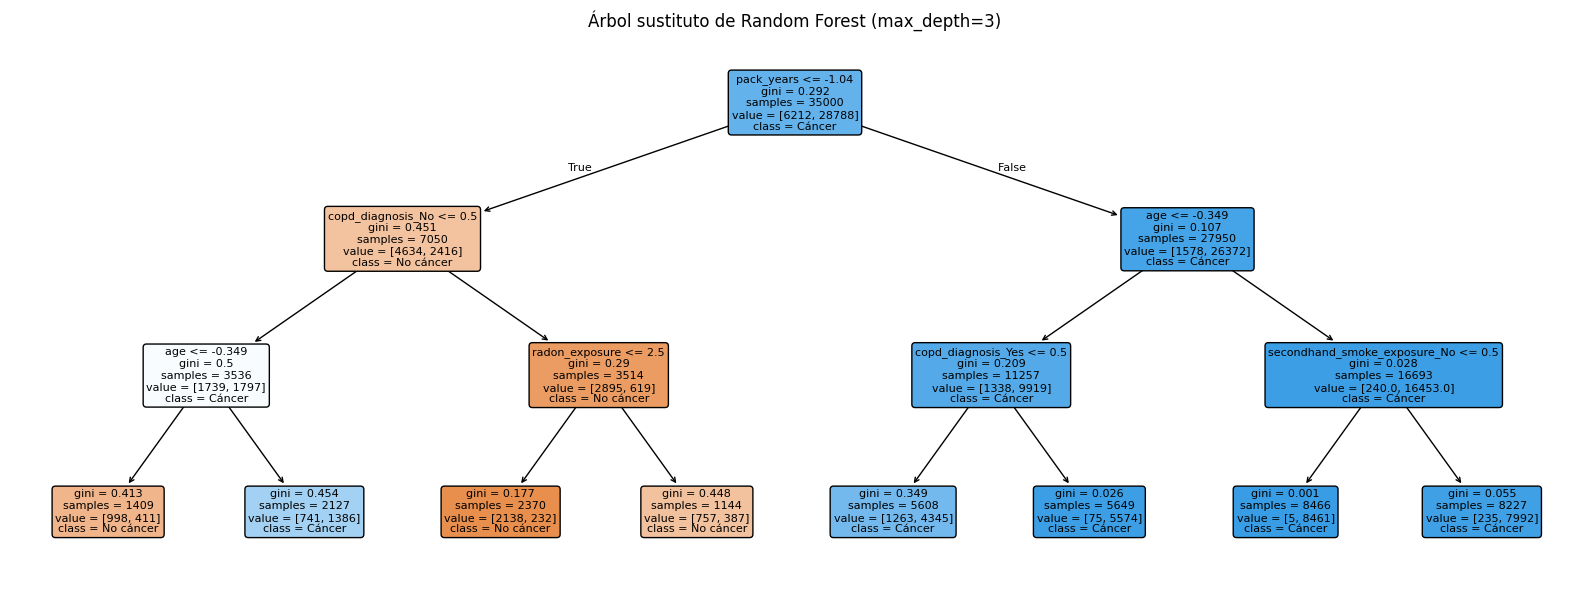


=== Árbol sustituto para XGBoost ===
Fidelidad (train) modelo vs árbol: 0.8933
Fidelidad (test)  modelo vs árbol: 0.8927

Reglas del árbol (forma textual):
|--- pack_years <= -1.03
|   |--- copd_diagnosis_No <= 0.50
|   |   |--- age <= -0.35
|   |   |   |--- class: 0
|   |   |--- age >  -0.35
|   |   |   |--- class: 1
|   |--- copd_diagnosis_No >  0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 0
|--- pack_years >  -1.03
|   |--- age <= -0.35
|   |   |--- copd_diagnosis_Yes <= 0.50
|   |   |   |--- class: 1
|   |   |--- copd_diagnosis_Yes >  0.50
|   |   |   |--- class: 1
|   |--- age >  -0.35
|   |   |--- secondhand_smoke_exposure_No <= 0.50
|   |   |   |--- class: 1
|   |   |--- secondhand_smoke_exposure_No >  0.50
|   |   |   |--- class: 1



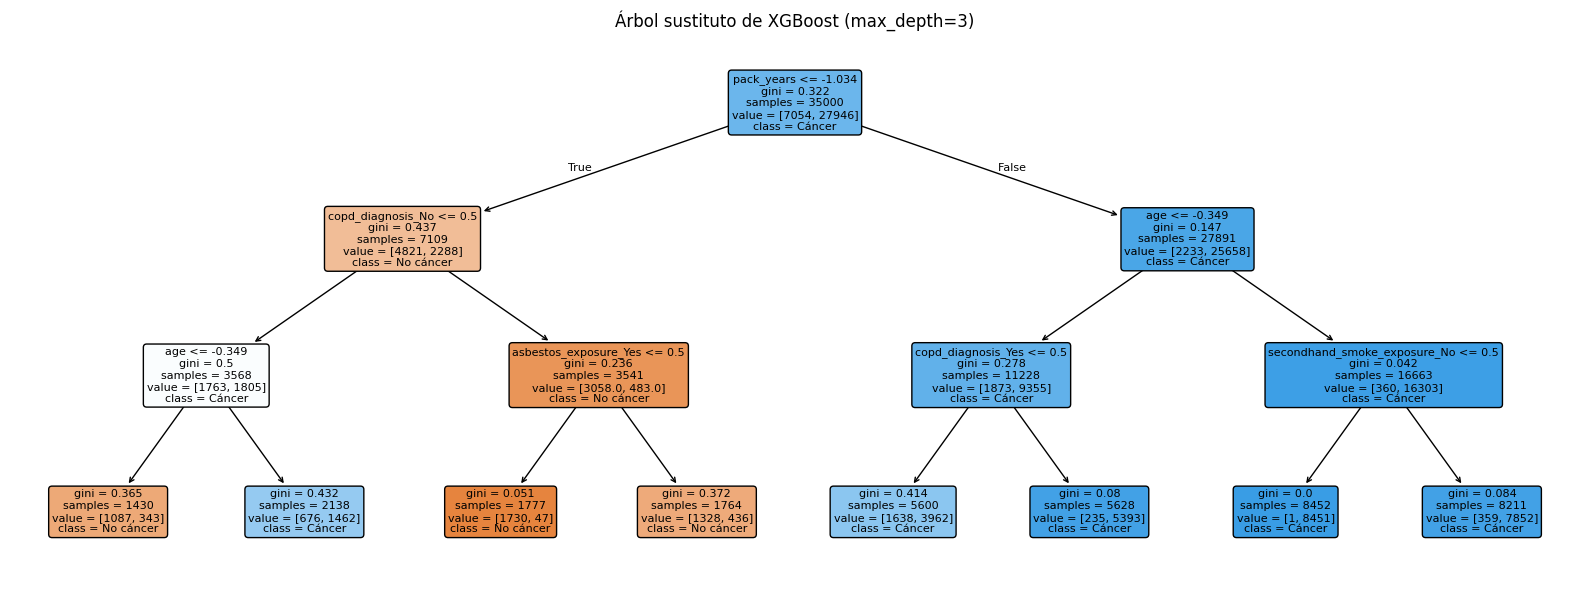


=== Árbol sustituto para SVM (RBF) ===
Fidelidad (train) modelo vs árbol: 0.8195
Fidelidad (test)  modelo vs árbol: 0.8195

Reglas del árbol (forma textual):
|--- pack_years <= -0.79
|   |--- pack_years <= -1.17
|   |   |--- radon_exposure <= 2.50
|   |   |   |--- class: 0
|   |   |--- radon_exposure >  2.50
|   |   |   |--- class: 0
|   |--- pack_years >  -1.17
|   |   |--- copd_diagnosis_No <= 0.50
|   |   |   |--- class: 0
|   |   |--- copd_diagnosis_No >  0.50
|   |   |   |--- class: 0
|--- pack_years >  -0.79
|   |--- copd_diagnosis_No <= 0.50
|   |   |--- age <= -0.64
|   |   |   |--- class: 1
|   |   |--- age >  -0.64
|   |   |   |--- class: 1
|   |--- copd_diagnosis_No >  0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 1



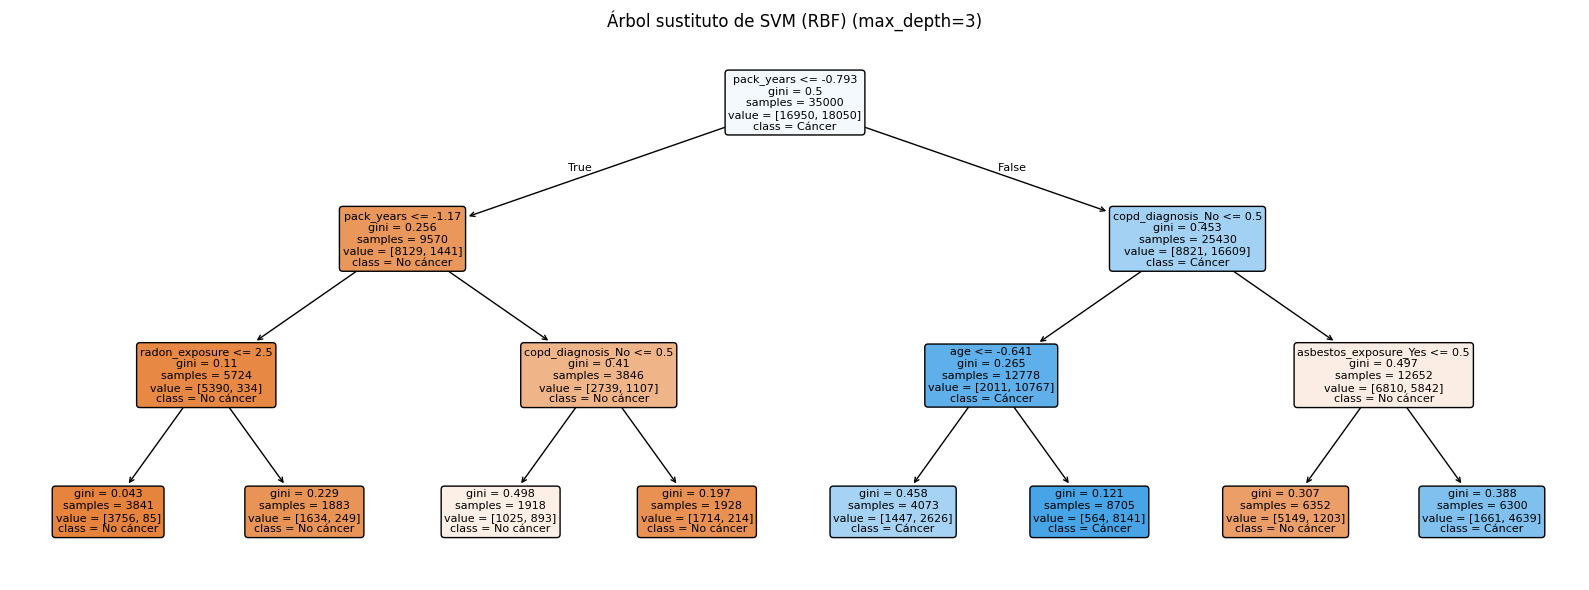


=== Árbol sustituto para Regresión Logística ===
Fidelidad (train) modelo vs árbol: 0.7992
Fidelidad (test)  modelo vs árbol: 0.7986

Reglas del árbol (forma textual):
|--- pack_years <= -0.31
|   |--- copd_diagnosis_No <= 0.50
|   |   |--- asbestos_exposure_No <= 0.50
|   |   |   |--- class: 1
|   |   |--- asbestos_exposure_No >  0.50
|   |   |   |--- class: 0
|   |--- copd_diagnosis_No >  0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 0
|--- pack_years >  -0.31
|   |--- copd_diagnosis_Yes <= 0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 1
|   |--- copd_diagnosis_Yes >  0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 1
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 1



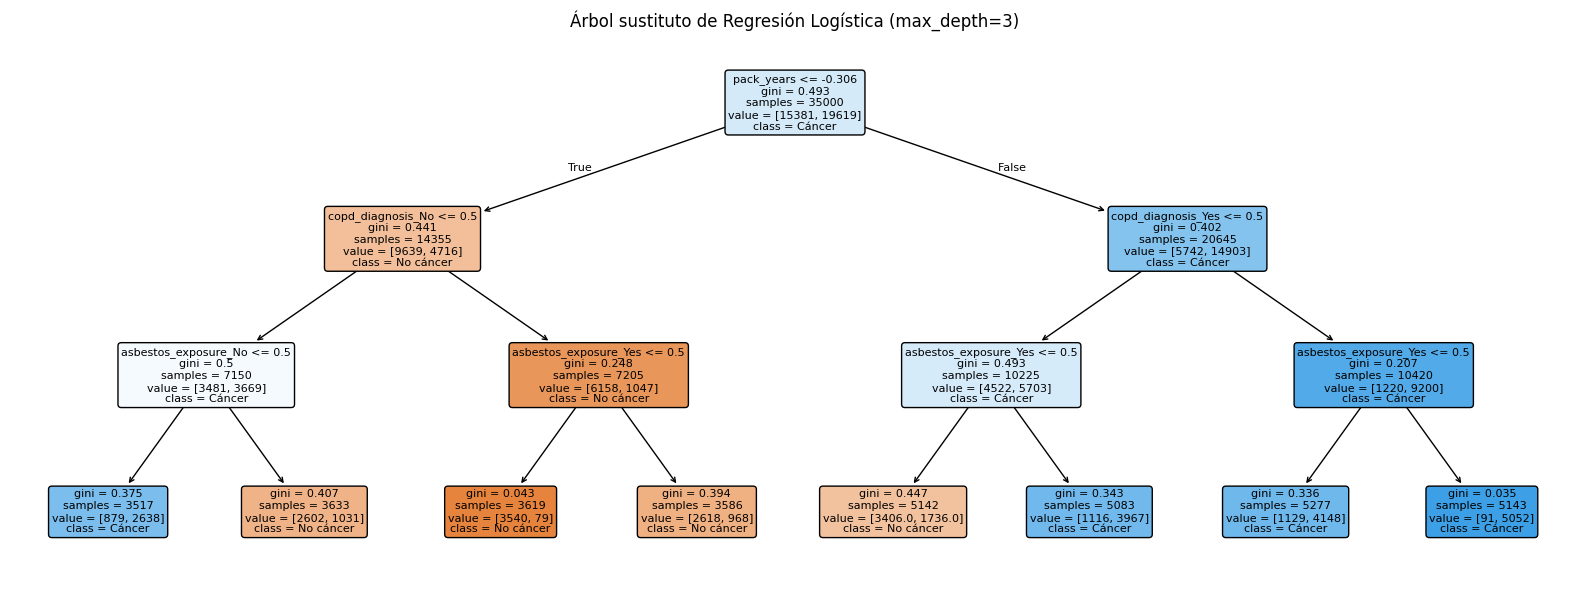


=== Árbol sustituto para LightGBM ===
Fidelidad (train) modelo vs árbol: 0.8527
Fidelidad (test)  modelo vs árbol: 0.8631

Reglas del árbol (forma textual):
|--- pack_years <= -1.04
|   |--- copd_diagnosis_No <= 0.50
|   |   |--- age <= -0.35
|   |   |   |--- class: 0
|   |   |--- age >  -0.35
|   |   |   |--- class: 1
|   |--- copd_diagnosis_No >  0.50
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 0
|--- pack_years >  -1.04
|   |--- age <= -0.35
|   |   |--- asbestos_exposure_Yes <= 0.50
|   |   |   |--- class: 1
|   |   |--- asbestos_exposure_Yes >  0.50
|   |   |   |--- class: 1
|   |--- age >  -0.35
|   |   |--- asbestos_exposure_No <= 0.50
|   |   |   |--- class: 1
|   |   |--- asbestos_exposure_No >  0.50
|   |   |   |--- class: 1



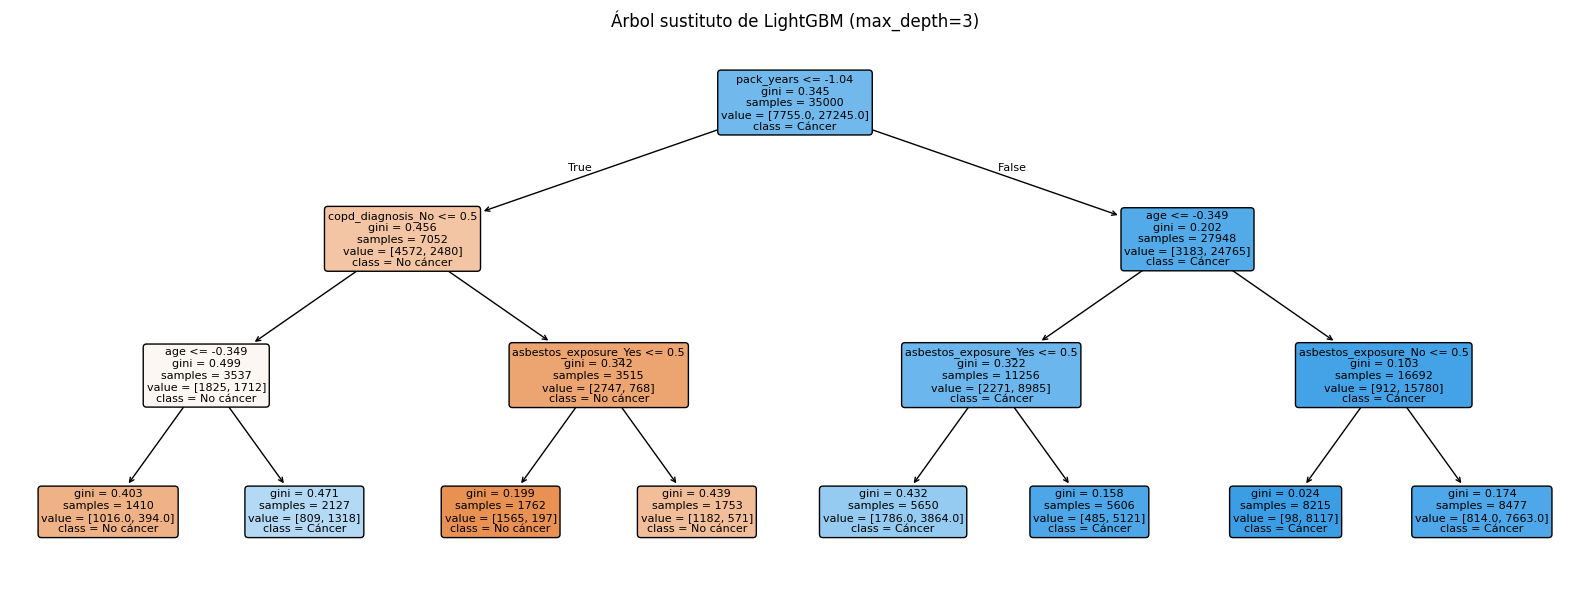

In [ ]:
feature_names = X_train.columns.tolist()

surrogate_rf = entrenar_arbol_sustituto(
    modelo=best_rf_model,
    X_train_model=X_train,
    X_test_model=X_test,
    feature_names=feature_names,
    nombre_modelo="Random Forest",
    max_depth=3  # puedes probar 2, 3, 4...
)

surrogate_xgb = entrenar_arbol_sustituto(
    modelo=best_xgb_model,
    X_train_model=X_train,
    X_test_model=X_test,
    feature_names=feature_names,
    nombre_modelo="XGBoost",
    max_depth=3
)

surrogate_svm = entrenar_arbol_sustituto(
    modelo=best_svm_model,
    X_train_model=X_train,   # o X_train_scaled si usaste eso
    X_test_model=X_test,     # idem
    feature_names=feature_names,
    nombre_modelo="SVM (RBF)",
    max_depth=3
)

surrogate_lr = entrenar_arbol_sustituto(
    modelo=best_logreg_model,
    X_train_model=X_train,   # o X_train_scaled
    X_test_model=X_test,
    feature_names=feature_names,
    nombre_modelo="Regresión Logística",
    max_depth=3
)

surrogate_lgbm = entrenar_arbol_sustituto(
    modelo=best_lgbm_model,
    X_train_model=X_train,
    X_test_model=X_test,
    feature_names=feature_names,
    nombre_modelo="LightGBM",
    max_depth=3
)
